In [8]:
import cv2
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from torch.functional import F
# Load image and bbox
#image = cv2.imread("./demo_pic.jpeg")
image = cv2.imread("./assets/colab/image_sportsfan.jpg")
with open('./assets/colab/bbox_sportsfan.json') as jsonfile:
    bbox = json.load(jsonfile)['bbox']
#bbox = [0,0,*np.flip(image.shape[:2])]
plt.rcParams['axes.facecolor'] = 'white'

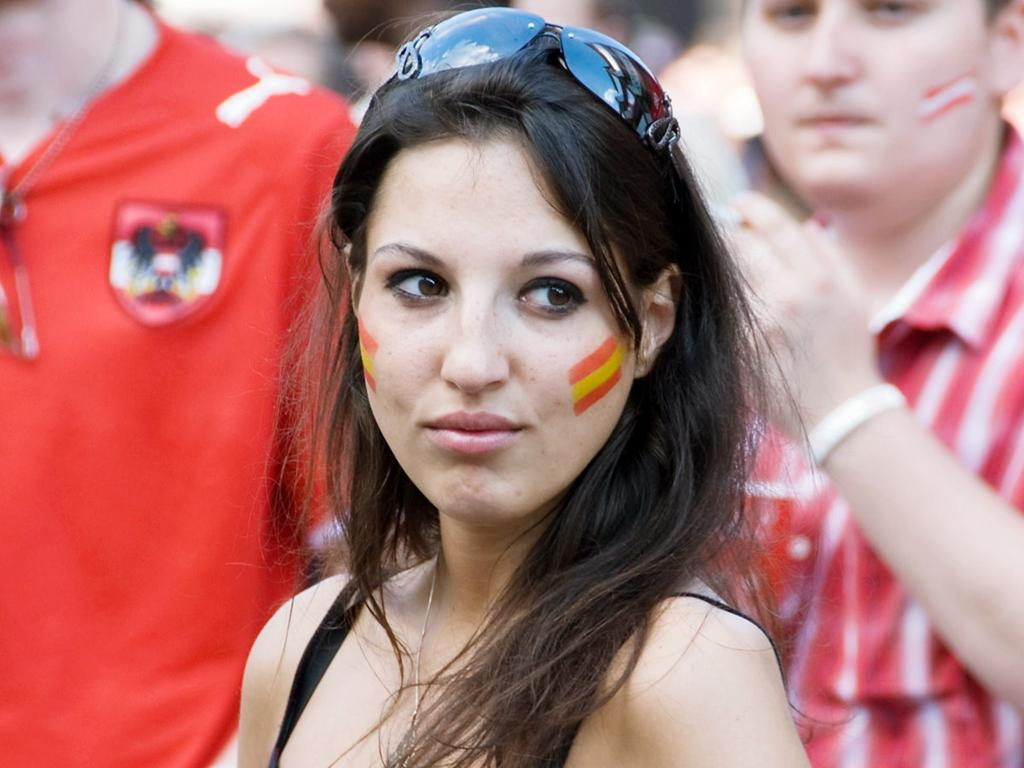

In [9]:
display(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

In [10]:
from spiga.inference.config import ModelConfig
from spiga.inference.framework import SPIGAFramework
from spiga.demo.visualize.layouts.plot_basics import BasicLayout
import copy
from spiga.demo.visualize.plotter import Plotter
# Process image
dataset = 'wflw'
processor = SPIGAFramework(ModelConfig(dataset))

SPIGA model loaded!


In [11]:
class FeatureHook:
    def __init__(self, module):
        self.module = module
        self.features = None
        self.hook = self.module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
        self.inp = input
    def remove(self):
        self.hook.remove()

# MTN Visualization

In [12]:
fe = FeatureHook(processor.model.visual_cnn)
processor.forward(image, [bbox])
output = fe.features
fe.remove()

C:\Users\fapro\Desktop\SPIGA\venv\lib\site-packages\torch\nn\functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
C:\Users\fapro\Desktop\SPIGA\venv\lib\site-packages\torch\nn\functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


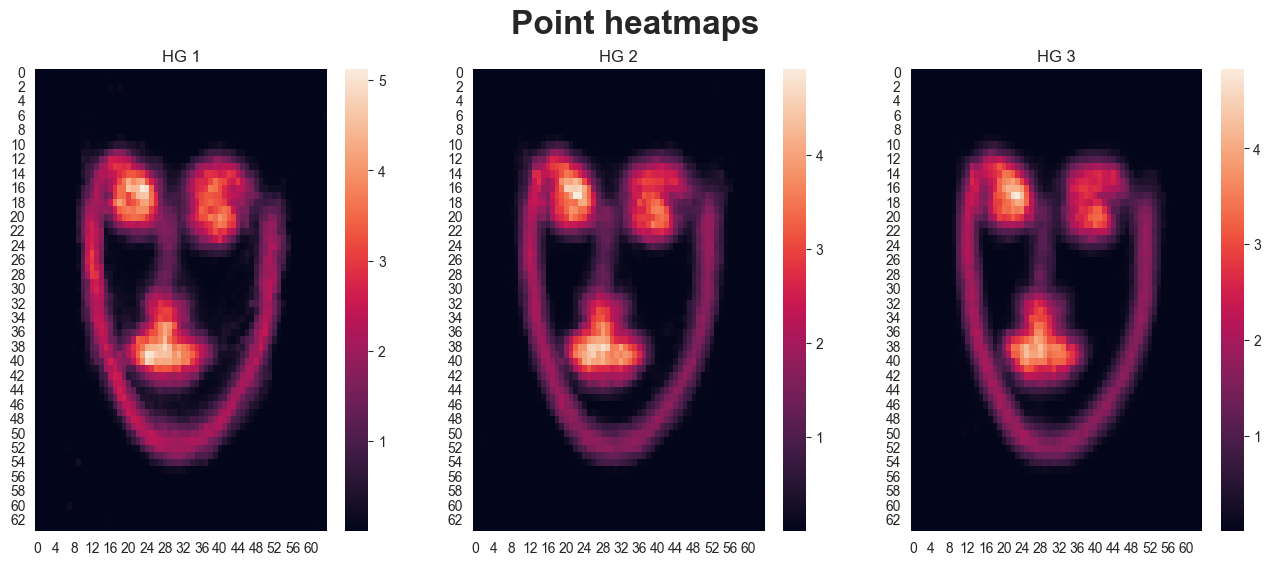

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6), dpi=100)
for num, ax in enumerate(axes):
    sns.heatmap(output['Heatmaps'][num][0].squeeze().cpu().detach().numpy().sum(axis=0),ax=ax)
    ax.set_title(f'HG {num + 1}')
plt.suptitle('Point heatmaps', fontweight ='bold', fontsize=24)
plt.show()

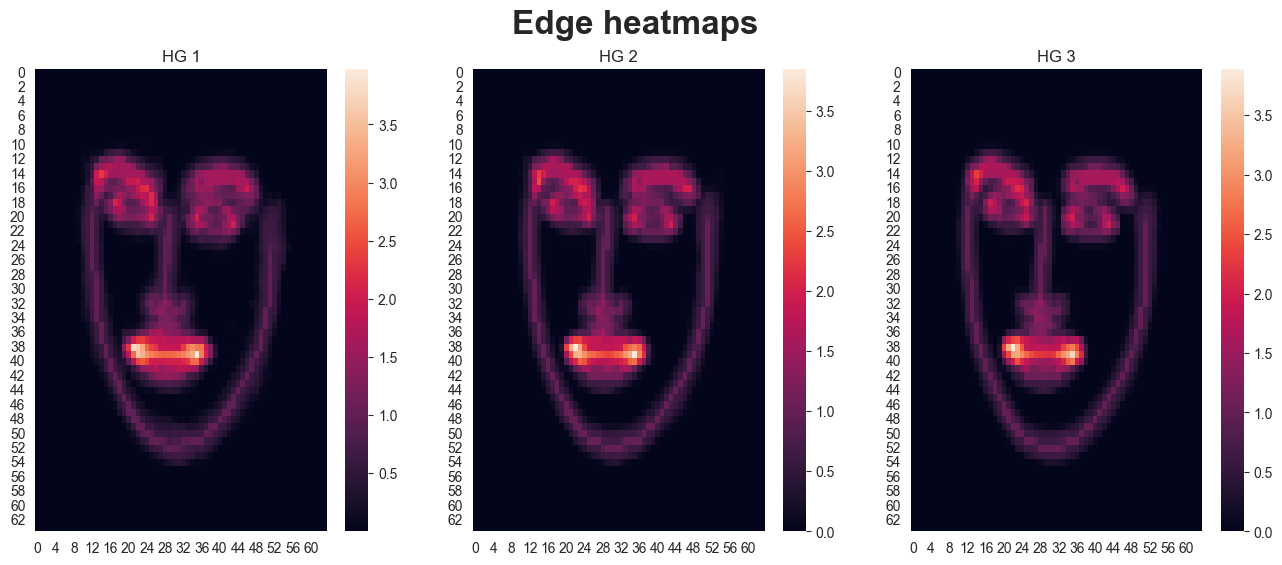

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6), dpi=100)
for num, ax in enumerate(axes):
    sns.heatmap(output['Heatmaps'][num][1].squeeze().cpu().detach().numpy().sum(axis=0),ax=ax)
    ax.set_title(f'HG {num + 1}')
plt.suptitle('Edge heatmaps', fontweight ='bold', fontsize=24)
plt.show()

In [15]:
visualization = []

In [16]:
for i in range(3):
    fe = FeatureHook(processor.model.visual_cnn.outs_features[i])
    processor.forward(image, [bbox])
    visualization.append(fe.features)
    fe.remove()

C:\Users\fapro\Desktop\SPIGA\venv\lib\site-packages\torch\nn\functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
C:\Users\fapro\Desktop\SPIGA\venv\lib\site-packages\torch\nn\functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


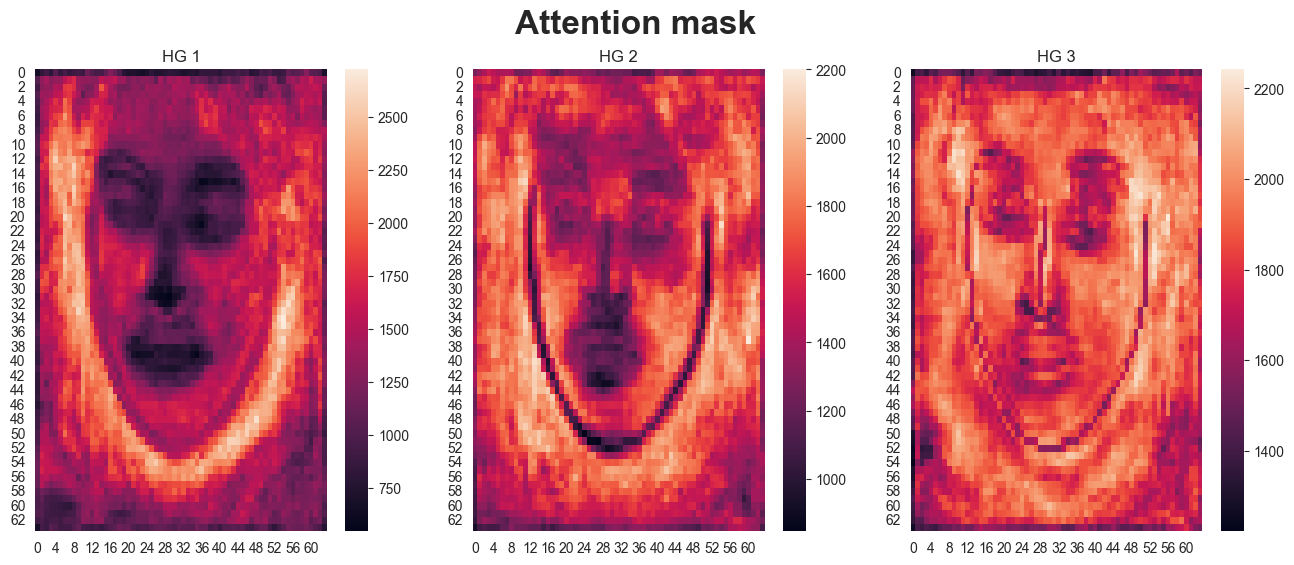

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6), dpi=100)
for num, ax in enumerate(axes):
    output = visualization[num].squeeze().cpu().detach().numpy().sum(axis=0)
    sns.heatmap(output, ax=ax)
    ax.set_title(f'HG {num + 1}')
plt.suptitle('Attention mask', fontweight ='bold', fontsize=24)
plt.show()

# Shape regressor visualization

In [18]:
features = processor.forward(image, [bbox])

C:\Users\fapro\Desktop\SPIGA\venv\lib\site-packages\torch\nn\functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
C:\Users\fapro\Desktop\SPIGA\venv\lib\site-packages\torch\nn\functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


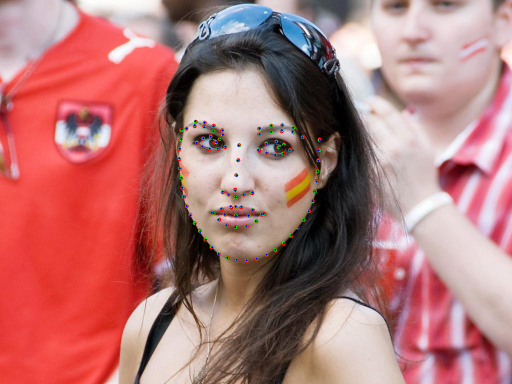

In [19]:
ldm = []

crop_bboxes = np.array(processor.pretreat(image, [bbox])[1])
bboxes = np.array([bbox])
colormap = [BasicLayout.colors['red'], BasicLayout.colors['green'], BasicLayout.colors['blue']]
x0,y0,w,h = bbox
canvas = copy.deepcopy(image)
for i in range(3):
    landmarks = features['Landmarks'][i].cpu().detach().numpy()
    landmarks = landmarks.transpose((1, 0, 2))
    landmarks = landmarks*processor.model_cfg.image_size
    landmarks_norm = (landmarks - crop_bboxes[:, 0:2]) / crop_bboxes[:, 2:4]
    landmarks_out = (landmarks_norm * bboxes[:, 2:4]) + bboxes[:, 0:2]
    landmarks_out = landmarks_out.transpose((1, 0, 2))


    landmarks = landmarks_out.tolist()[0]

    plotter = Plotter()
    canvas = plotter.landmarks.draw_landmarks(canvas, landmarks,thick = 4-i,colors=(colormap[i], BasicLayout.colors['red']))

(h, w) = canvas.shape[:2]
canvas = cv2.resize(canvas, (512, int(h*512/w)))
canvas = Image.fromarray(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
display(canvas)

In [20]:
GAT = features['GATProb'][-1].squeeze()[-1].cpu().detach()
GAT -= GAT.min(1, keepdim=True)[0]
GAT /= GAT.max(1, keepdim=True)[0]

![Reference](https://wywu.github.io/projects/LAB/support/WFLW_annotation.png)

In [32]:
start = 54
cond = GAT[start] > 0.01
ind = cond.nonzero()
ind = ind.squeeze().tolist()
if isinstance(ind, int):
    ind = [ind]

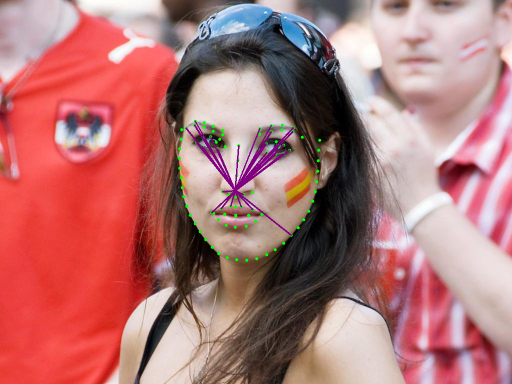

In [33]:
#Inference
features = processor.inference(image, [bbox])
# Prepare variables
x0,y0,w,h = bbox
canvas = copy.deepcopy(image)
landmarks = np.array(features['landmarks'][0])
headpose = np.array(features['headpose'][0])

# Plot features
plotter = Plotter()
canvas = plotter.landmarks.draw_landmarks(canvas, landmarks, start_point=start, end_point=ind)
# Show image results
(h, w) = canvas.shape[:2]
canvas = cv2.resize(canvas, (512, int(h*512/w)))
canvas = Image.fromarray(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
display(canvas)

# Final output

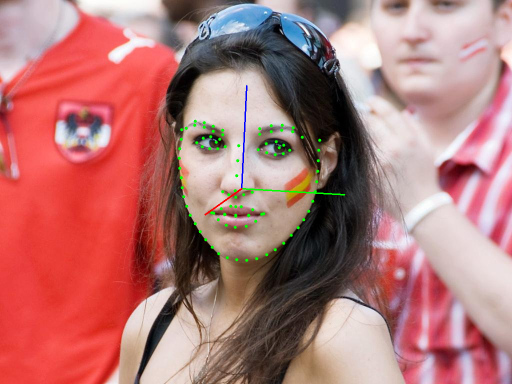

In [23]:
#Inference
features = processor.inference(image, [bbox])
# Prepare variables
x0,y0,w,h = bbox
canvas = copy.deepcopy(image)
landmarks = np.array(features['landmarks'][0])
headpose = np.array(features['headpose'][0])

# Plot features
plotter = Plotter()
canvas = plotter.landmarks.draw_landmarks(canvas, landmarks)
canvas = plotter.hpose.draw_headpose(canvas, [x0,y0,x0+w,y0+h], headpose[:3], headpose[3:], euler=True)
# Show image results
(h, w) = canvas.shape[:2]
canvas = cv2.resize(canvas, (512, int(h*512/w)))
canvas = Image.fromarray(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
display(canvas)